In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import sys
sys.path.append('../')
from nc_csf.models import BaselineCausalForestDML, NCCausalForestDML
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('data/cleaned_rhc.csv')
df.head()

,Y,A,lstctdte,cardiohx,chfhx,dementhx,psychhx,chrpulhx,renalhx,liverhx,...,ninsclas_Medicare,ninsclas_Medicare_and_Medicaid,ninsclas_No_insurance,ninsclas_Private_and_Medicare,race_black,race_other,pafi1,paco21,ph1,hema1
0,30,0,11382,0,0,0,0,1,0,0,...,1,0,0,0,0,0,68.00000,40.0,7.359375,58.000000
1,30,1,11844,1,1,0,0,0,0,0,...,0,0,0,1,0,0,218.31250,34.0,7.329102,32.500000
2,30,1,12400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,275.50000,16.0,7.359375,21.097656
3,30,0,11182,0,0,0,0,0,0,0,...,0,0,0,1,0,0,156.65625,30.0,7.459961,26.296875
4,2,1,12036,0,0,0,0,0,0,0,...,1,0,0,0,0,0,478.00000,17.0,7.229492,24.000000


In [6]:
exclude_cols = ['Y', 'A', 'pafi1', 'paco21', 'ph1', 'hema1']
X_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total number of X variables: {len(X_cols)}")
print(f"X variables: {X_cols}")

Total number of X variables: 68
X variables: ['lstctdte', 'cardiohx', 'chfhx', 'dementhx', 'psychhx', 'chrpulhx', 'renalhx', 'liverhx', 'gibledhx', 'malighx', 'immunhx', 'transhx', 'amihx', 'age', 'sex_Female', 'edu', 'surv2md1', 'das2d3pc', 'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1', 'resp1', 'temp1', 'alb1', 'bili1', 'crea1', 'sod1', 'pot1', 'wtkilo1', 'dnr1', 'resp_Yes', 'card_Yes', 'neuro_Yes', 'gastr_Yes', 'renal_Yes', 'meta_Yes', 'hema_Yes', 'seps_Yes', 'trauma_Yes', 'ortho_Yes', 'cat1_CHF', 'cat1_Cirrhosis', 'cat1_Colon_Cancer', 'cat1_Coma', 'cat1_COPD', 'cat1_Lung_Cancer', 'cat1_MOSF_Malignancy', 'cat1_MOSF_Sepsis', 'cat2_Cirrhosis', 'cat2_Colon_Cancer', 'cat2_Coma', 'cat2_Lung_Cancer', 'cat2_MOSF_Malignancy', 'cat2_MOSF_Sepsis', 'income1', 'income2', 'income3', 'ca_Yes', 'ca_Metastatic', 'ninsclas_Medicaid', 'ninsclas_Medicare', 'ninsclas_Medicare_and_Medicaid', 'ninsclas_No_insurance', 'ninsclas_Private_and_Medicare', 'race_black', 'race_other']


NEGATIVE CONTROL ASSUMPTIONS VERIFICATION

CONDITION 1: CONSISTENCY
Check that Y and W are well-defined functions of (A, Z)
--------------------------------------------------------------------------------

1a. Y as a function of (A, Z):
    R² = 0.0178
    Coefficients: A=-1.0214, Z[pafi1]=0.0048, Z[paco21]=0.0836
    ✓ Y depends on (A,Z)

1b. ph1 as a function of (A, Z):
    R² = 0.2382
    Coefficients: A=-0.0260, Z[pafi1]=0.0000, Z[paco21]=-0.0041
    ✓ ph1 depends on (A,Z)

1b. hema1 as a function of (A, Z):
    R² = 0.0681
    Coefficients: A=-1.6753, Z[pafi1]=0.0010, Z[paco21]=0.1471
    ✓ hema1 depends on (A,Z)

CONDITION 2: NEGATIVE CONTROL ACTIONS
Z should not directly affect Y (Z ⊥ Y | conditioning on confounders)
Simplified check: Z ⊥ Y (marginal independence as proxy)
--------------------------------------------------------------------------------
   pafi1           <-> Y               :  0.0467  [✓ PASS]
   paco21          <-> Y               :  0.1060  [✓ PASS]

   Condit

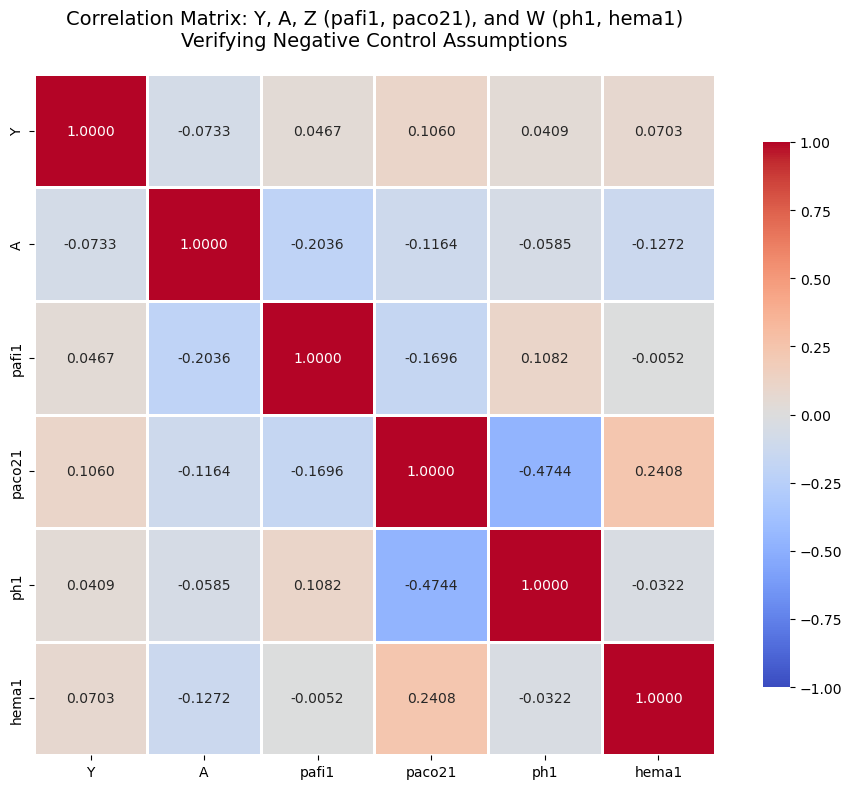

In [7]:
Z = df[["pafi1", "paco21"]].copy() 
W = df[["ph1", "hema1"]].copy()

# Define the variables
Z_vars = ["pafi1", "paco21"]
W_vars = ["ph1", "hema1"]
Y_var = "Y"
A_var = "A"

print("="*80)
print("NEGATIVE CONTROL ASSUMPTIONS VERIFICATION")
print("="*80)

# ============================================================================
# CONDITION 1: CONSISTENCY - Y = Y(A,Z), W = W(A,Z)
# ============================================================================
print("\n" + "="*80)
print("CONDITION 1: CONSISTENCY")
print("="*80)
print("Check that Y and W are well-defined functions of (A, Z)")
print("-"*80)

# Y = Y(A, Z) - Check if Y can be predicted from A and Z
X_for_Y = df[[A_var] + Z_vars].values
y_for_Y = df[Y_var].values
model_Y = LinearRegression().fit(X_for_Y, y_for_Y)
y_pred = model_Y.predict(X_for_Y)
r2_Y = r2_score(y_for_Y, y_pred)

print(f"\n1a. Y as a function of (A, Z):")
print(f"    R² = {r2_Y:.4f}")
print(f"    Coefficients: A={model_Y.coef_[0]:.4f}, Z[pafi1]={model_Y.coef_[1]:.4f}, Z[paco21]={model_Y.coef_[2]:.4f}")
print(f"    {'✓ Y depends on (A,Z)' if r2_Y > 0.01 else '✗ Y may not depend on (A,Z)'}")

# W = W(A, Z) - Check if W can be predicted from A and Z
for w in W_vars:
    X_for_W = df[[A_var] + Z_vars].values
    y_for_W = df[w].values
    model_W = LinearRegression().fit(X_for_W, y_for_W)
    w_pred = model_W.predict(X_for_W)
    r2_W = r2_score(y_for_W, w_pred)
    
    print(f"\n1b. {w} as a function of (A, Z):")
    print(f"    R² = {r2_W:.4f}")
    print(f"    Coefficients: A={model_W.coef_[0]:.4f}, Z[pafi1]={model_W.coef_[1]:.4f}, Z[paco21]={model_W.coef_[2]:.4f}")
    print(f"    {'✓ ' + w + ' depends on (A,Z)' if r2_W > 0.01 else '✗ ' + w + ' may not depend on (A,Z)'}")

# ============================================================================
# CONDITION 2: NEGATIVE CONTROL ACTIONS - Y(a,z) = Y(a), ∀a ∈ A
# ============================================================================
print("\n" + "="*80)
print("CONDITION 2: NEGATIVE CONTROL ACTIONS")
print("="*80)
print("Z should not directly affect Y (Z ⊥ Y | conditioning on confounders)")
print("Simplified check: Z ⊥ Y (marginal independence as proxy)")
print("-"*80)

for z in Z_vars:
    corr = df[z].corr(df[Y_var])
    abs_corr = abs(corr)
    status = "✓ PASS" if abs_corr < 0.15 else "✗ FAIL" if abs_corr > 0.3 else "⚠ MARGINAL"
    print(f"   {z:15s} <-> {Y_var:15s} : {corr:7.4f}  [{status}]")

# Additional check: After controlling for A, does Z still affect Y?
print("\n   Conditional independence check (controlling for A):")
for z in Z_vars:
    # Stratify by treatment A
    for a_val in df[A_var].unique():
        subset = df[df[A_var] == a_val]
        if len(subset) > 10:  # Ensure sufficient sample size
            corr_conditional = subset[z].corr(subset[Y_var])
            print(f"   {z} <-> {Y_var} | A={a_val}: {corr_conditional:7.4f}")

# ============================================================================
# CONDITION 3: NEGATIVE CONTROL OUTCOMES - W(a,z) = W, ∀a ∈ A, z ∈ Z
# ============================================================================
print("\n" + "="*80)
print("CONDITION 3: NEGATIVE CONTROL OUTCOMES")
print("="*80)
print("W should not be directly affected by A or Z")
print("-"*80)

print("\n3a. W should be independent of A (W ⊥ A):")
for w in W_vars:
    corr = df[w].corr(df[A_var])
    abs_corr = abs(corr)
    status = "✓ PASS" if abs_corr < 0.15 else "✗ FAIL" if abs_corr > 0.3 else "⚠ MARGINAL"
    print(f"   {w:15s} <-> {A_var:15s} : {corr:7.4f}  [{status}]")

print("\n3b. W should be independent of Z (W ⊥ Z):")
for w in W_vars:
    for z in Z_vars:
        corr = df[w].corr(df[z])
        abs_corr = abs(corr)
        status = "✓ PASS" if abs_corr < 0.15 else "✗ FAIL" if abs_corr > 0.3 else "⚠ MARGINAL"
        print(f"   {w:15s} <-> {z:15s} : {corr:7.4f}  [{status}]")

# ============================================================================
# VISUALIZATION: Correlation Matrix
# ============================================================================
key_vars = [Y_var, A_var] + Z_vars + W_vars
corr_matrix_key = df[key_vars].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_key, 
            annot=True,
            fmt='.4f',
            cmap='coolwarm', 
            center=0, 
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=2,
            cbar_kws={"shrink": 0.8},
            ax=ax)

plt.title('Correlation Matrix: Y, A, Z (pafi1, paco21), and W (ph1, hema1)\n' + 
          'Verifying Negative Control Assumptions', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

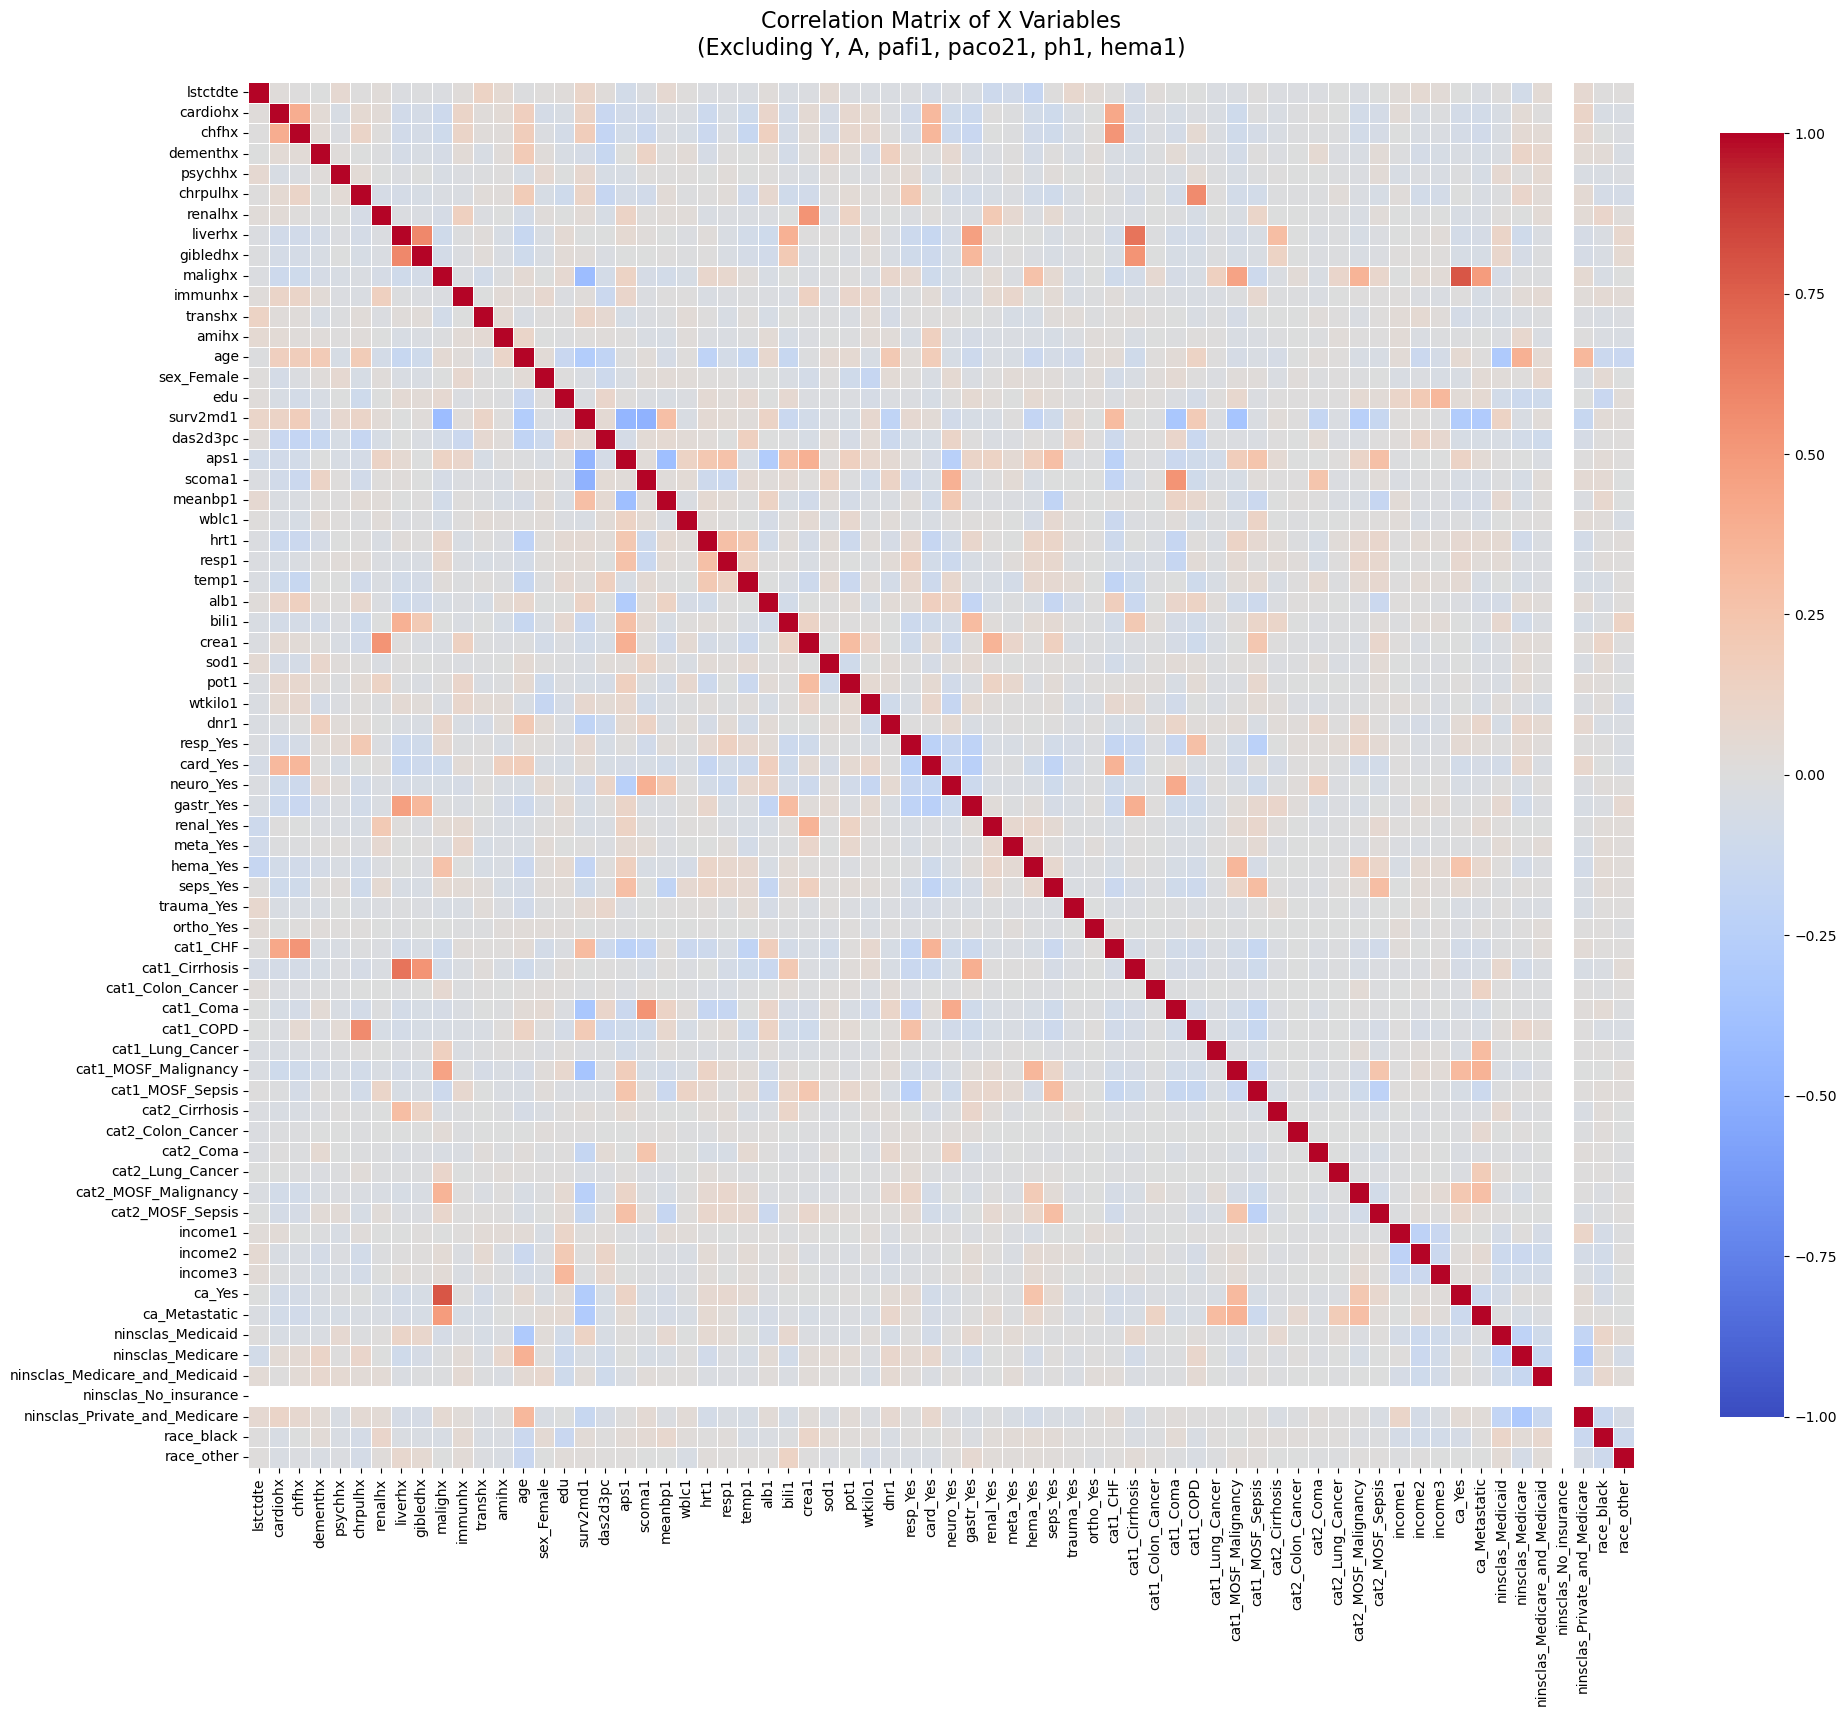


Highly Correlated Variable Pairs (|correlation| > 0.7):
malighx                        <-> ca_Yes                         :  0.7836


In [8]:
correlation_matrix = df[X_cols].corr()

plt.figure(figsize=(20, 18))

sns.heatmap(correlation_matrix, 
            cmap='coolwarm', 
            center=0, 
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot=False)

plt.title('Correlation Matrix of X Variables\n(Excluding Y, A, pafi1, paco21, ph1, hema1)', 
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated pairs (absolute correlation > 0.7)
print("\n" + "="*80)
print("Highly Correlated Variable Pairs (|correlation| > 0.7):")
print("="*80)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                corr_value
            ))

# Sort by absolute correlation value
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for var1, var2, corr in high_corr_pairs:
    print(f"{var1:30s} <-> {var2:30s} : {corr:7.4f}")

In [9]:
Y = df["Y"].values
A = df["A"].values.astype(int)
X_colnames = [col for col in df.columns if col not in ["Y", "A", "pafi1", "paco21", "ph1", "hema1"]]
X = df[X_colnames]
Z = df[["pafi1", "paco21"]]
W = df[["ph1", "hema1"]]

In [10]:
# Initialize results storage
results = []

# Number of X columns to iterate through
n_X_cols = len(X_colnames)
print(f"Starting experiment: Iterating through {n_X_cols} X columns as hidden confounder U")
print(f"Each iteration: 70/30 train-test split, comparing Baseline vs NC-CSF")
print("="*80)

Starting experiment: Iterating through 68 X columns as hidden confounder U
Each iteration: 70/30 train-test split, comparing Baseline vs NC-CSF


In [11]:
# Main experiment loop: Hide each X column as U
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

for idx, u_colname in enumerate(tqdm(X_colnames, desc="Processing X columns")):
    try:
        # 1. Select X columns EXCLUDING the current U column
        X_without_u_colnames = [col for col in X_colnames if col != u_colname]
        X_without_u = df[X_without_u_colnames].values
        
        # 2. Train-test split (70/30)
        indices = np.arange(len(Y))
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=0.3, 
            random_state=42, 
            stratify=A
        )
        
        # Split all data
        X_train = X_without_u[train_idx]
        X_test = X_without_u[test_idx]
        Y_train = Y[train_idx]
        Y_test = Y[test_idx]
        A_train = A[train_idx]
        A_test = A[test_idx]
        Z_train = Z.values[train_idx]
        Z_test = Z.values[test_idx]
        W_train = W.values[train_idx]
        W_test = W.values[test_idx]
        
        # 3. Fit Baseline CausalForestDML (ignores Z and W)
        baseline_model = BaselineCausalForestDML(
            n_estimators=100,
            min_samples_leaf=20,
            random_state=42
        )
        baseline_model.fit_baseline(X=X_train, A=A_train, Y=Y_train)
        baseline_te = baseline_model.effect(X_test)
        
        # 4. Fit NC CausalForestDML (uses Z and W)
        nc_model = NCCausalForestDML(
            n_estimators=100,
            min_samples_leaf=20,
            random_state=42
        )
        nc_model.fit_nc(X=X_train, A=A_train, Y=Y_train, Z=Z_train, W=W_train)
        nc_te = nc_model.effect(X_test)
        
        # 5. Calculate statistics
        baseline_stats = {
            'mean': np.mean(baseline_te),
            'std': np.std(baseline_te),
            'min': np.min(baseline_te),
            'max': np.max(baseline_te)
        }
        
        nc_stats = {
            'mean': np.mean(nc_te),
            'std': np.std(nc_te),
            'min': np.min(nc_te),
            'max': np.max(nc_te)
        }
        
        # 6. Store results
        results.append({
            'u_column': u_colname,
            'iteration': idx + 1,
            'baseline_mean': baseline_stats['mean'],
            'baseline_std': baseline_stats['std'],
            'baseline_min': baseline_stats['min'],
            'baseline_max': baseline_stats['max'],
            'nc_mean': nc_stats['mean'],
            'nc_std': nc_stats['std'],
            'nc_min': nc_stats['min'],
            'nc_max': nc_stats['max'],
            'n_features': len(X_without_u_colnames),
            'train_size': len(train_idx),
            'test_size': len(test_idx)
        })
        
    except Exception as e:
        print(f"\nError processing column {u_colname} (iteration {idx+1}): {str(e)}")
        continue

print(f"\n{'='*80}")
print(f"Experiment completed! Processed {len(results)} out of {n_X_cols} columns")
print(f"{'='*80}")

Processing X columns: 100%|██████████| 68/68 [16:58<00:00, 14.98s/it]


Experiment completed! Processed 68 out of 68 columns


In [15]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

print("Results Summary:")
print("="*80)
print(f"Total iterations: {len(results_df)}")
print(f"\nFirst few results:")
print(results_df.head(10))

print(f"\n\nBaseline Model Statistics (across all iterations):")
print(f"  Mean Treatment Effect: {results_df['baseline_mean'].mean():.4f} ± {results_df['baseline_mean'].std():.4f}")
print(f"  Std of Treatment Effect: {results_df['baseline_std'].mean():.4f}")
print(f"  Min Treatment Effect: {results_df['baseline_min'].min():.4f}")
print(f"  Max Treatment Effect: {results_df['baseline_max'].max():.4f}")

print(f"\n\nNC-CSF Model Statistics (across all iterations):")
print(f"  Mean Treatment Effect: {results_df['nc_mean'].mean():.4f} ± {results_df['nc_mean'].std():.4f}")
print(f"  Std of Treatment Effect: {results_df['nc_std'].mean():.4f}")
print(f"  Min Treatment Effect: {results_df['nc_min'].min():.4f}")
print(f"  Max Treatment Effect: {results_df['nc_max'].max():.4f}")

Results Summary:
Total iterations: 68

First few results:
   u_column  iteration  baseline_mean  baseline_std  baseline_min  \
0  lstctdte          1      -1.113185      0.763924     -3.142347   
1  cardiohx          2      -0.625658      0.694458     -2.314081   
2     chfhx          3      -0.648147      0.721737     -2.668250   
3  dementhx          4      -0.682672      0.715524     -2.805015   
4   psychhx          5      -0.693364      0.680063     -2.639632   
5  chrpulhx          6      -0.625543      0.695923     -2.525754   
6   renalhx          7      -0.644038      0.724517     -2.508625   
7   liverhx          8      -0.674878      0.721168     -2.814867   
8  gibledhx          9      -0.691792      0.647480     -2.721950   
9   malighx         10      -0.683214      0.711895     -2.652734   

   baseline_max   nc_mean    nc_std    nc_min    nc_max  n_features  \
0      2.370325 -1.353209  0.741734 -3.430307  1.055372          67   
1      2.120050 -0.661476  0.770907 -2.6

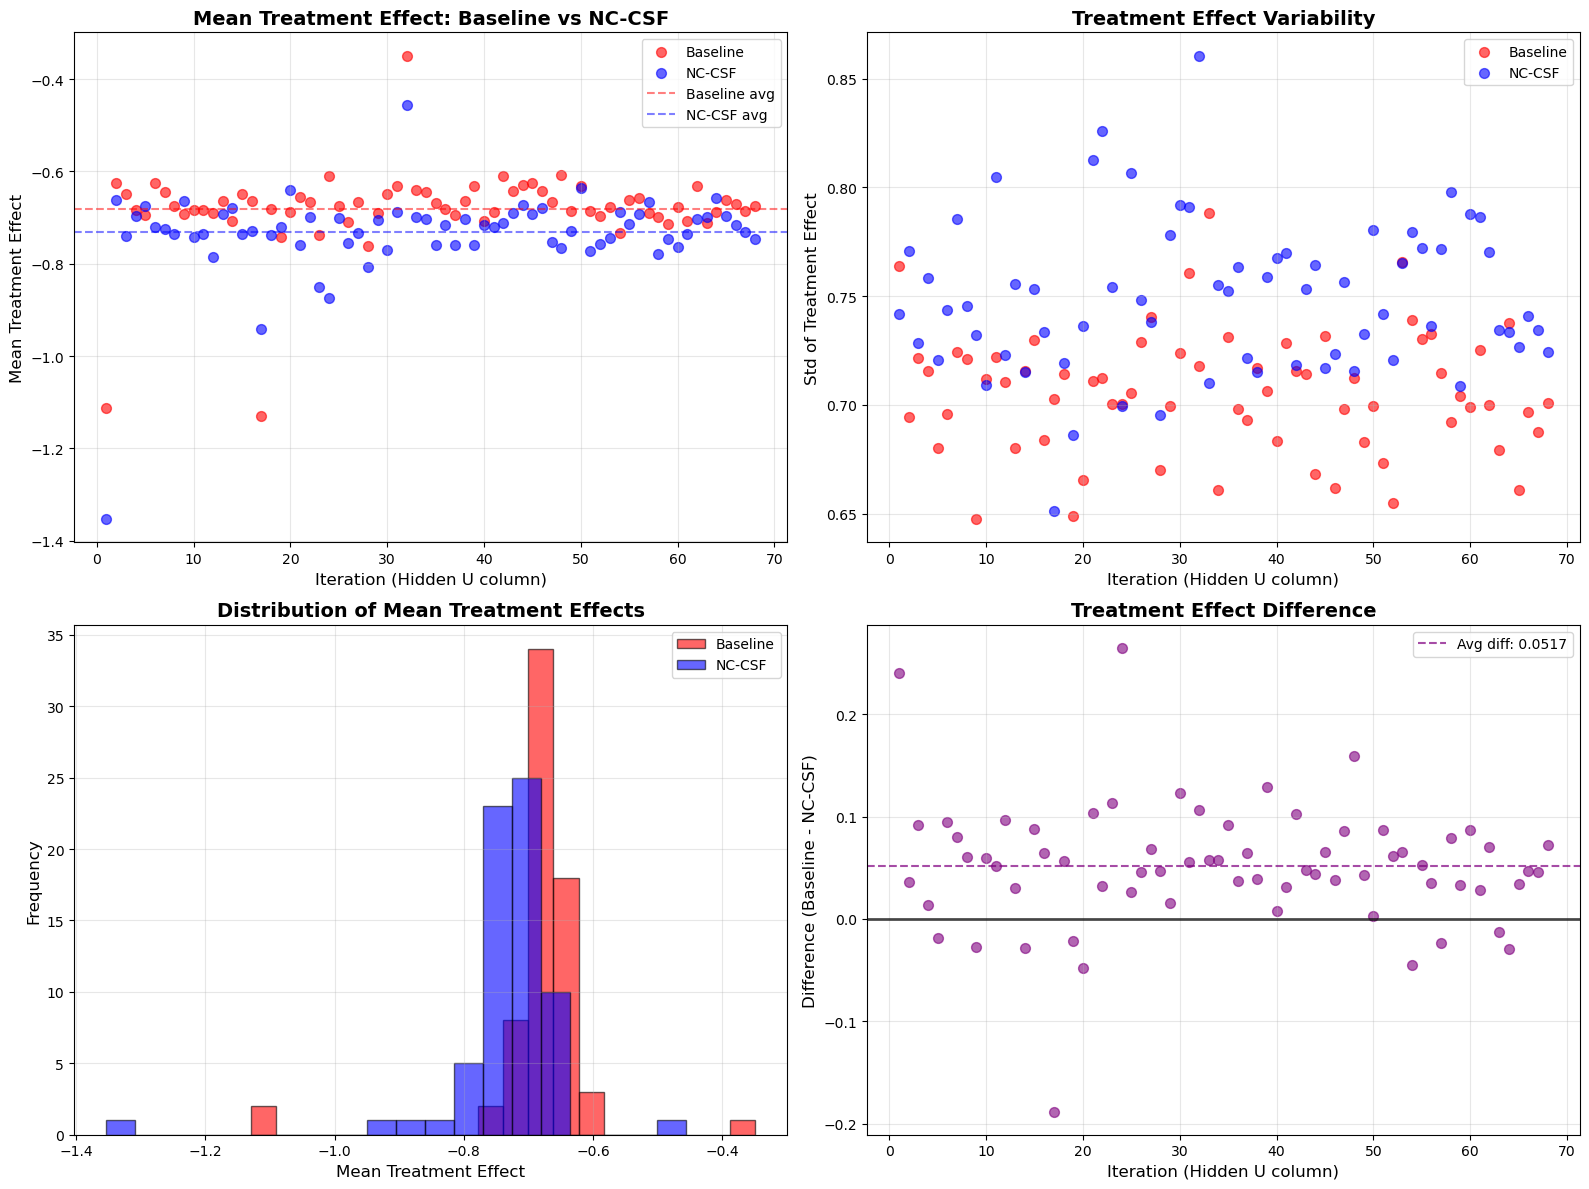


Key Finding:
  Average difference (Baseline - NC-CSF): 0.0517


In [16]:
# Visualize results: Compare Baseline vs NC-CSF

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Mean Treatment Effect comparison
axes[0, 0].scatter(results_df['iteration'], results_df['baseline_mean'], 
                   alpha=0.6, label='Baseline', s=50, color='red')
axes[0, 0].scatter(results_df['iteration'], results_df['nc_mean'], 
                   alpha=0.6, label='NC-CSF', s=50, color='blue')
axes[0, 0].axhline(y=results_df['baseline_mean'].mean(), color='red', 
                   linestyle='--', alpha=0.5, label='Baseline avg')
axes[0, 0].axhline(y=results_df['nc_mean'].mean(), color='blue', 
                   linestyle='--', alpha=0.5, label='NC-CSF avg')
axes[0, 0].set_xlabel('Iteration (Hidden U column)', fontsize=12)
axes[0, 0].set_ylabel('Mean Treatment Effect', fontsize=12)
axes[0, 0].set_title('Mean Treatment Effect: Baseline vs NC-CSF', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Standard Deviation comparison
axes[0, 1].scatter(results_df['iteration'], results_df['baseline_std'], 
                   alpha=0.6, label='Baseline', s=50, color='red')
axes[0, 1].scatter(results_df['iteration'], results_df['nc_std'], 
                   alpha=0.6, label='NC-CSF', s=50, color='blue')
axes[0, 1].set_xlabel('Iteration (Hidden U column)', fontsize=12)
axes[0, 1].set_ylabel('Std of Treatment Effect', fontsize=12)
axes[0, 1].set_title('Treatment Effect Variability', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Distribution of mean effects
axes[1, 0].hist(results_df['baseline_mean'], bins=20, alpha=0.6, 
                label='Baseline', color='red', edgecolor='black')
axes[1, 0].hist(results_df['nc_mean'], bins=20, alpha=0.6, 
                label='NC-CSF', color='blue', edgecolor='black')
axes[1, 0].set_xlabel('Mean Treatment Effect', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution of Mean Treatment Effects', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Difference between Baseline and NC-CSF
results_df['diff_mean'] = results_df['baseline_mean'] - results_df['nc_mean']
axes[1, 1].scatter(results_df['iteration'], results_df['diff_mean'], 
                   alpha=0.6, s=50, color='purple')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.7)
axes[1, 1].axhline(y=results_df['diff_mean'].mean(), color='purple', 
                   linestyle='--', alpha=0.7, label=f"Avg diff: {results_df['diff_mean'].mean():.4f}")
axes[1, 1].set_xlabel('Iteration (Hidden U column)', fontsize=12)
axes[1, 1].set_ylabel('Difference (Baseline - NC-CSF)', fontsize=12)
axes[1, 1].set_title('Treatment Effect Difference', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Finding:")
print(f"  Average difference (Baseline - NC-CSF): {results_df['diff_mean'].mean():.4f}")